In [1]:
import cv2
import numpy as np
import openvino as ov

In [2]:
def Main():
    camera = cv2.VideoCapture(source)
    while(True):
        ret, frame = camera.read()

        if not ret:
            break
        cv2.imshow("Webcam",frame)

        if cv2.waitKey(1) & 0xff == ord('q'):
            break

    camera.release()
    cv2.destroyAllWindows()

In [3]:
source = "data/gg.mp4"

if __name__ == '__name__':
    Main()

In [4]:
core = ov.Core()

model_face = core.read_model(model='models/face-detection-adas-0001.xml') 
compiled_model_face = core.compile_model (model = model_face, device_name="CPU")

input_layer_face = compiled_model_face.input(0) 
output_layer_face = compiled_model_face.output(0)

print("Input shape:", input_layer_face.shape) 
print("Output shape:", output_layer_face.shape)

model_emo = core.read_model(model=r'models/emotions-recognition-retail-0003.xml') 
compiled_model_emo = core.compile_model (model = model_emo, device_name="CPU")

input_layer_emo = compiled_model_emo.input(0) 
output_layer_emo = compiled_model_emo.output(0)

print("Input shape:", input_layer_emo.shape) 
print("Output shape:", output_layer_emo.shape)

model_ag = core.read_model(model=r'models/age-gender-recognition-retail-0013.xml') 
compiled_model_ag = core.compile_model (model = model_ag, device_name="CPU")

input_layer_ag = compiled_model_ag.input(0) 
output_layer_ag = compiled_model_ag.output

print("Input shape:", input_layer_ag.shape) 
print("Output shape:", output_layer_ag)

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]
Input shape: [1,3,64,64]
Output shape: [1,5,1,1]
Input shape: [1,3,62,62]
Output shape: <bound method PyCapsule.output of <CompiledModel:
inputs[
<ConstOutput: names[data] shape[1,3,62,62] type: f32>
]
outputs[
<ConstOutput: names[prob] shape[1,2,1,1] type: f32>,
<ConstOutput: names[age_conv3, fc3_a] shape[1,1,1,1] type: f32>
]>>


In [5]:
def preprocess(frame, input_layer):
    N, input_channels, input_height, input_width = input_layer.shape
    
    resized_frame = cv2.resize(frame, (input_width, input_height))
    transposed_frame = resized_frame.transpose(2,0,1)
    input_frame = np. expand_dims(transposed_frame, 0)
    
    return input_frame

In [6]:
def find_faceboxes(frame, results, confidence_threshold):
    results = results.squeeze()
    
    scores = results[:,2]
    boxes = results[:,-4:]
    
    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]
    
    frame_h, frame_w, frame_channels = frame.shape
    face_boxes = face_boxes*np.array([frame_w, frame_h, frame_w, frame_h])
    face_boxes = face_boxes.astype(np.int64)
    
    return face_boxes, scores

In [7]:
def draw_age_gender_emotion(face_boxes, frame):
    
    show_frame = frame.copy()
    EMOTION_NAMES = ['neutral', 'happy', 'sad', 'surprise', 'anger']
    for i in range(len(face_boxes)):
        
            xmin, ymin, xmax, ymax = face_boxes[i]
            face = frame[ymin:ymax, xmin:xmax]
            
            #---emotion---
            input_frame = preprocess(face, input_layer_emo)
            results_emo = compiled_model_emo([input_frame])[output_layer_emo]
        
            results_emo = results_emo.squeeze()
            index = np.argmax(results_emo)
            #---emotion---
            
            
            # --- age gender ---
            input_frame_ag = preprocess(face, input_layer_ag)
            results_ag = compiled_model_ag([input_frame_ag])
            age, gender = results_ag[1], results_ag[0]
            
            age = np.squeeze(age)
            age = int(age*100)
            
            gender = np.squeeze(gender)
            
            if (gender[0] >= 0.65):
                gender = "female"
                box_color = (255,153,255)
            elif (gender[1] >= 0.65):
                gender = "male"
                box_color = (255,204,154)
            else :
                gender = "unknown"
                box_color = (0,0,0)
                
            
            #print("Age:",age)
            #print("Gender:",gender)
            #print(results_ag)
            # --- age gender ---
            
            fontScale = frame.shape[1]/750
           
            text = gender + ' ' + str(age) + ' ' + EMOTION_NAMES[index]
            cv2.putText(show_frame,text,(xmin,ymin), cv2.FONT_HERSHEY_SIMPLEX, fontScale, box_color ,1)
            cv2.rectangle(img=show_frame, pt1=(xmin,ymin), pt2=(xmax,ymax), color= box_color ,thickness=1)
    return show_frame
            

In [8]:
def Main():
    camera = cv2.VideoCapture(source)
    while(True):
        ret, frame = camera.read()

        if not ret:
            break
        nput_frame = preprocess(frame, input_layer_face)
        results = compiled_model_face([input_frame])[output_layer_face]
        
        confidence_threshold = .95
        face_boxes, scores = find_faceboxes(frame, results, confidence_threshold)
        show_frame = draw_age_gender_emotion(face_boxes, frame)

        cv2.imshow("Webcam",show_frame)

        if cv2.waitKey(1) & 0xff == ord('q'):
            break

    camera.release()
    cv2.destroyAllWindows()

In [9]:
confidence_threshold = .95
source = "data/gg.mp4"

if __name__ == '__name__':
    Main()

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]
Input shape: [1,3,64,64]
Output shape: [1,5,1,1]
Input shape: [1,3,62,62]
Output shape: <bound method PyCapsule.output of <CompiledModel:
inputs[
<ConstOutput: names[data] shape[1,3,62,62] type: f32>
]
outputs[
<ConstOutput: names[prob] shape[1,2,1,1] type: f32>,
<ConstOutput: names[age_conv3, fc3_a] shape[1,1,1,1] type: f32>
]>>


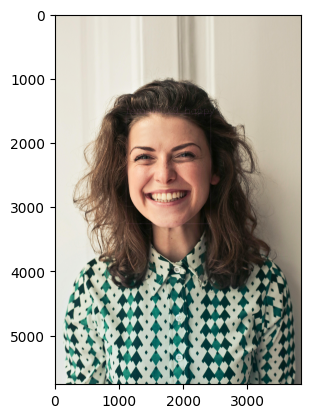

In [10]:
import openvino as ov
import cv2
import numpy as np
import matplotlib.pyplot as plt

core = ov.Core()
model_face = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model_face = core.compile_model (model = model_face, device_name="CPU")

input_layer_face = compiled_model_face.input(0)
output_layer_face = compiled_model_face.output(0)

print("Input shape:", input_layer_face.shape)
print("Output shape:", output_layer_face.shape)

model_emo = core.read_model(model='models/emotions-recognition-retail-0003.xml')
compiled_model_emo = core.compile_model (model = model_emo, device_name="CPU")

input_layer_emo = compiled_model_emo.input(0)
output_layer_emo = compiled_model_emo.output(0)

print("Input shape:", input_layer_emo.shape)
print("Output shape:", output_layer_emo.shape)

model_ag = core.read_model(model='models/age-gender-recognition-retail-0013.xml')
compiled_model_ag = core.compile_model (model = model_ag, device_name="CPU")

input_layer_ag = compiled_model_ag.input(0)
output_layer_ag = compiled_model_ag.output

print("Input shape:", input_layer_ag.shape)
print("Output shape:", output_layer_ag)

def preprocess(image, input_layer):
    N, input_channels, input_height, input_width = input_layer.shape
   
    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2,0,1)
    input_image = np. expand_dims(transposed_image, 0)
   
    return input_image

def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()
   
    scores = results[:,2]
    boxes = results[:,-4:]
   
    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]
   
    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)
   
    return face_boxes, scores

def draw_faceboxes(image, face_boxes, scores):
    show_image = image.copy()
   
    for i in range(len(face_boxes)):
       
        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin,ymin), pt2=(xmax,ymax), color=(0,200,0),thickness=2)
                     
    return show_image

def draw_emotions(face_boxes, image, show_image):
   
    for i in range(len(face_boxes)):
       
            xmin, ymin, xmax, ymax = face_boxes[i]
            face = image[ymin:ymax, xmin:xmax]
       

            cv2.putText(show_image,text,(xmin,ymin), cv2.FONT_HERSHEY_SIMPLEX, 5, (0,200,0),8)
           
def draw_age_gender(face_boxes, image):
   
    show_image = image.copy()
    EMOTION_NAMES = ['neutral', 'happy', 'sad', 'surprise', 'anger']
    for i in range(len(face_boxes)):
       
            xmin, ymin, xmax, ymax = face_boxes[i]
            face = image[ymin:ymax, xmin:xmax]
           
            #---emotion---
            input_image = preprocess(face, input_layer_emo)
            results_emo = compiled_model_emo([input_image])[output_layer_emo]
       
            results_emo = results_emo.squeeze()
            index = np.argmax(results_emo)
            #---emotion---
           
           
            # --- age gender ---
            input_image_ag = preprocess(face, input_layer_ag)
            results_ag = compiled_model_ag([input_image_ag])
            age, gender = results_ag[1], results_ag[0]
           
            age = np.squeeze(age)
            age = int(age*100)
           
            gender = np.squeeze(gender)
           
            if (gender[0] >= 0.65):
                gender = "female"
                box_color = (255,153,255)
            elif (gender[1] >= 0.65):
                gender = "male"
                box_color = (255,204,154)
            else :
                gender = "unknown"
                box_color = (0,0,0)
               
           
            #print("Age:",age)
            #print("Gender:",gender)
            #print(results_ag)
            # --- age gender ---
           
            fontScale = image.shape[1]/750
           
            text = gender + ' ' + str(age) + ' ' + EMOTION_NAMES[index]
            cv2.putText(show_image,text,(xmin,ymin), cv2.FONT_HERSHEY_SIMPLEX, fontScale, box_color ,1)
            cv2.rectangle(img=show_image, pt1=(xmin,ymin), pt2=(xmax,ymax), color= box_color ,thickness=1)
    return show_image
           

image = cv2.imread("data/qwq.jpg")

input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]

confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_age_gender(face_boxes, image)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))


In [11]:
import cv2

def Main():
    camera = cv2.VideoCapture(0)  
    while True:
        ret, frame = camera.read()
       
        if not ret:
            break
           
        input_frame = preprocess(frame, input_layer_face)
        results = compiled_model_face([input_frame])[output_layer_face]
       
        face_boxes, scores = find_faceboxes(frame, results, confidence_threshold)
        show_frame = draw_age_gender_emotion(face_boxes, frame)
       
        cv2.imshow("Webcam", show_frame)
       
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    camera.release()
    cv2.destroyAllWindows()

confidence_threshold = .95
source = 0

if __name__ == '__main__':
    Main()
